In [4]:
!pip install transformers
!pip install codecarbon

You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertConfig, TFBertForSequenceClassification
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle

from codecarbon import EmissionsTracker

pd.options.display.max_colwidth = None
%matplotlib inline

## Importing data sets

In [6]:
#importint datasets

df_train = pd.read_csv('data/train.txt', header = None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test = pd.read_csv('data/test.txt', header = None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_valid = pd.read_csv('data/val.txt', header = None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')

df_valid2 = df_valid.copy()

In [7]:
#train dataset
print(df_train.shape)
df_train.head()

(16000, 2)


,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,love
4,i am feeling grouchy,anger


In [8]:
#test dataset
print(df_test.shape)
df_test.head()

(2000, 2)


,Input,Sentiment
0,im feeling rather rotten so im not very ambitious right now,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i don t ever want her to feel like i m ashamed with her,sadness
3,i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived,joy
4,i was feeling a little vain when i did this one,sadness


In [9]:
#Valid dataset
print(df_valid.shape)
df_valid.head()

(2000, 2)


,Input,Sentiment
0,im feeling quite sad and sorry for myself but ill snap out of it soon,sadness
1,i feel like i am still looking at a blank canvas blank pieces of paper,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Sentiment, dtype: int64


<AxesSubplot:ylabel='Sentiment'>

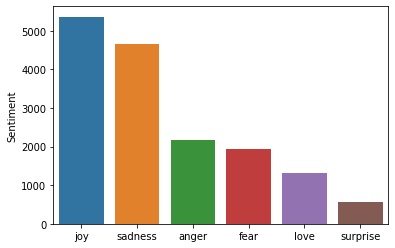

In [10]:
#Train distributions targets sentiment
data = df_train.Sentiment.value_counts()
print(data)
sns.barplot(x = data.index, y = data)

In [11]:
#Encoding sentiments
encoded_dict = {'anger':0,'fear':1, 'joy':2, 'love':3, 'sadness':4, 'surprise':5}
df_train['Sentiment'] = df_train.Sentiment.map(encoded_dict)
df_test['Sentiment'] = df_test.Sentiment.map(encoded_dict)
df_valid['Sentiment'] = df_valid.Sentiment.map(encoded_dict)

In [12]:
df_train.head()

,Input,Sentiment
0,i didnt feel humiliated,4
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,4
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,3
4,i am feeling grouchy,0


In [13]:
df_test.head()

,Input,Sentiment
0,im feeling rather rotten so im not very ambitious right now,4
1,im updating my blog because i feel shitty,4
2,i never make her separate from me because i don t ever want her to feel like i m ashamed with her,4
3,i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived,2
4,i was feeling a little vain when i did this one,4


In [14]:
df_valid.head()

,Input,Sentiment
0,im feeling quite sad and sorry for myself but ill snap out of it soon,4
1,i feel like i am still looking at a blank canvas blank pieces of paper,4
2,i feel like a faithful servant,3
3,i am just feeling cranky and blue,0
4,i can have for a treat or if i am feeling festive,2


In [15]:
X_train = df_train.Input
y_train = df_train.Sentiment

X_test = df_test.Input
y_test = df_test.Sentiment

X_valid = df_valid.Input
y_valid = df_valid.Sentiment

## Preparing DATA

In [16]:
#Tokenize

nombre_modelo = 'bert-base-multilingual-uncased'
#nombre_modelo = 'distilbert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(nombre_modelo)
train_encodings = tokenizer(X_train.to_list(), truncation=True, padding=True, return_tensors="tf")

In [17]:
MAX_SEQUENCE_LENGTH=train_encodings['input_ids'].shape[1]

test_encodings = tokenizer(X_test.to_list(), truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors="tf")

valid_encondings = tokenizer(X_valid.to_list(), truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors="tf")

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))
valid_dataset = tf.data.Dataset.from_tensor_slices((
    dict(valid_encondings),
    y_valid
))


## Fine Tuning with BERT

In [19]:
N_SENTIMENT = len(encoded_dict)

#definimos modelo de clasificación
config = BertConfig.from_pretrained(nombre_modelo, hidden_dropout_prob=0.2, num_labels=N_SENTIMENT)

model = TFBertForSequenceClassification.from_pretrained(nombre_modelo, config=config)
model.bert.trainable = True #Freeze BERT layers

# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  167356416 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  4614      
Total params: 167,361,030
Trainable params: 167,361,030
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#main loop
batch_size=32
N_EPOCHS = 3
tracker = EmissionsTracker(project_name="BERT Sentiment Analysis",
                           output_dir="emissions/",
                           measure_power_secs=3600
                          )

tracker.start()

history=model.fit(train_dataset.batch(batch_size), epochs=N_EPOCHS, batch_size=batch_size, validation_data=test_dataset.batch(batch_size))

emissions: float = tracker.stop()
print(emissions)

[codecarbon INFO @ 13:35:45] [setup] RAM Tracking...
[codecarbon INFO @ 13:35:45] [setup] GPU Tracking...
[codecarbon INFO @ 13:35:45] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 13:35:45] [setup] CPU Tracking...
[codecarbon WARNING @ 13:35:45] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:35:47] CPU Model on constant consumption mode: Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz
[codecarbon INFO @ 13:35:47] >>> Tracker's metadata:
[codecarbon INFO @ 13:35:47]   Platform system: Linux-4.14.281-212.502.amzn2.x86_64-x86_64-with-glibc2.2.5
[codecarbon INFO @ 13:35:47]   Python version: 3.8.2
[codecarbon INFO @ 13:35:47]   Available RAM : 15.374 GB
[codecarbon INFO @ 13:35:47]   CPU count: 4
[codecarbon INFO @ 13:35:47]   CPU model: Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz
[codecarbon INFO @ 13:35:47]   GPU count: 1
[codecarbon INFO @ 13:35:47]   GPU model: 1 x Tesla T4


Epoch 1/3
Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-07-29 13:35:47.796 tensorflow-2-6-gpu--ml-g4dn-xlarge-0dac2104acc07d6f4758a14ad24a:33 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-07-29 13:35:47.821 tensorflow-2-6-gpu--ml-g4dn-xlarge-0dac2104acc07d6f4758a14ad24a:33 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
500/500 [==============================] - 285s 537ms/step - loss: 0.8173 - accuracy: 0.7040 - val_loss: 0.2479 - val_accuracy: 0.9140
Epoch 2/3
 95/500 [====>.........................] - ETA: 3:34 - loss: 0.3047 - accuracy: 0.8990

In [ ]:
#Ploting results

import matplotlib.pyplot as plt
%matplotlib inline

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Fine-tuning BERT Sentiment Analysis')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Evaluation

In [ ]:
#Training evaluation
score,acc = model.evaluate(train_dataset.batch(batch_size), verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

In [ ]:
#Test evaluation
score,acc = model.evaluate(test_dataset.batch(batch_size), verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

In [ ]:
#Valid evaluation
score,acc = model.evaluate(valid_dataset.batch(batch_size), verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

## Predictions

In [ ]:
# function to return key for any value
def get_key(val):
    for key, value in encoded_dict.items():
         if val == value:
             return key
 
    return "key doesn't exist"

In [ ]:
predict = model.predict(valid_dataset.batch(batch_size))

In [ ]:
predict_proba = tf.nn.softmax(predict.logits)
predict_classes = np.argmax(predict_proba, 1)
predict_classes

In [ ]:
df_valid2['predicted'] = [get_key(x) for x in predict_classes]

In [ ]:
df_valid2.iloc[60:75]

In [ ]:
#Confusion matrix
cf_matrix = confusion_matrix(y_true=df_valid2.Sentiment, y_pred=df_valid2.predicted, labels = list(encoded_dict))
plt.figure(figsize=(15,5))
ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')
ax.set_title("Confusion Matrix")

## Random Sentences Prediction

In [ ]:
#Simple text prediction
sentences = ["im feeling quite sad and sorry for myself but ill snap out of it soon", 
             "Today is my cousin's birthday party, I'm happy now", "I'm so lonely today, need some company", 
             "im updating my blog because i feel shitty", "I'm furious now, need to punch someone"]

In [ ]:
predict_sentences = tokenizer(sentences, truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors="tf")
predict_dataset = tf.data.Dataset.from_tensor_slices((
    dict(predict_sentences),
))

In [ ]:
predict = model.predict(predict_dataset.batch(batch_size))
predict_proba = tf.nn.softmax(predict.logits)
predict_classes = np.argmax(predict_proba, 1)

In [ ]:
for i in range(len(predict_classes)):
  print(sentences[i],": ",get_key(predict_classes[i]))

## Saving model

In [ ]:
# save
save_model_path = 'model/'

model.save('model/bert_sentiment_model')


In [ ]:
#testing and load model
model_load = tf.keras.models.load_model('model/bert_sentiment_model/')
model.summary()

In [ ]:
#Simple text prediction
sentences = ["im feeling quite sad and sorry for myself but ill snap out of it soon", 
             "Today is my cousin's birthday party, I'm happy now", "I'm so lonely today, need some company", 
             "im updating my blog because i feel shitty", "I'm furious now, need to punch someone"]

In [ ]:
predict_sentences = tokenizer(sentences, truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors="tf")
predict_dataset = tf.data.Dataset.from_tensor_slices((
    dict(predict_sentences),
))

In [ ]:
predict = model_load.predict(predict_dataset.batch(batch_size))
predict_proba = tf.nn.softmax(predict.logits)
predict_classes = np.argmax(predict_proba, 1)